In [2]:
import os
import glob
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt 



In [16]:
file_path = '../individual_book_train/*'
all_files = glob.glob(file_path)
print(all_files)

agg_ls = []

['../individual_book_train/stock_13.csv', '../individual_book_train/stock_10.csv', '../individual_book_train/stock_38.csv', '../individual_book_train/stock_39.csv', '../individual_book_train/stock_11.csv', '../individual_book_train/stock_29.csv', '../individual_book_train/stock_15.csv', '../individual_book_train/stock_14.csv', '../individual_book_train/stock_28.csv', '../individual_book_train/stock_16.csv', '../individual_book_train/stock_17.csv', '../individual_book_train/stock_124.csv', '../individual_book_train/stock_118.csv', '../individual_book_train/stock_70.csv', '../individual_book_train/stock_8.csv', '../individual_book_train/stock_64.csv', '../individual_book_train/stock_58.csv', '../individual_book_train/stock_59.csv', '../individual_book_train/stock_9.csv', '../individual_book_train/stock_119.csv', '../individual_book_train/stock_125.csv', '../individual_book_train/stock_98.csv', '../individual_book_train/stock_67.csv', '../individual_book_train/stock_73.csv', '../individua

In [3]:
def create_df(filename):
    df = pd.read_csv(filename)
    return df

# Callum & Cecilia Code
# Code to calculate Weighted Average Price for a Stock at a time.
def add_wap(stock1):
    stock1["WAP"] = (stock1["bid_price1"] * stock1["ask_size1"] + stock1["ask_price1"] * stock1["bid_size1"]) / (stock1["bid_size1"] + stock1["ask_size1"])
    return stock1

def calc_log_returns(stock1):

    # Creating empty list to store the log returns for each time period.
    log_r1 = []
    # Getting an array of unique time IDs from teh first column of the dataframe (is this the index assigned automatically?)
    time_IDs = np.unique(stock1.iloc[:, 0])

    # For every unique time id
    for i in range(len(time_IDs)):
        
        # Calculating the seconds in bucket and WAP values for rows where the time ID matches the current ID. 
        sec = stock1.loc[stock1.iloc[:, 0] == time_IDs[i], 'seconds_in_bucket'].values
        price = stock1.loc[stock1.iloc[:, 0] == time_IDs[i], 'WAP'].values

        # Calculating the log returns for this time period
        log_r = np.log(price[1:] / price[0:(len(price) - 1)])
        
        # Adding the log returns for this time period to the list. 
        log_r1.append(pd.DataFrame({'time': sec[1:], 'log_return': log_r}))
        # Check if any time periods were skipped.
        time_no_change = np.setdiff1d(np.arange(1, 601), log_r1[i]['time'].values)
        # Anytime periods that were skipped set them to have a log return of 0
        if len(time_no_change) > 0:
            new_df = pd.DataFrame({'time': time_no_change, 'log_return': 0})
            log_r1[i] = pd.concat([log_r1[i], new_df])
            log_r1[i] = log_r1[i].sort_values(by='time')

    return log_r1


# Function to compute the volatility from the log returns. 
def comp_vol(x):
    return np.sqrt(np.sum(x ** 2))

def calc_volatility(log_r1):
    # List to store the volatility values for each time period. 
    vol = []
# For every time period
    for i in range(len(log_r1)):
        # We assign each log return to a time bucket (group of 30 seconds)
        log_r1[i]['time_bucket'] = np.ceil(log_r1[i]['time'] / 30)
        # Compute the volatility for each time bucket using the comp_vol function.
        vol.append(log_r1[i].groupby('time_bucket')['log_return'].agg(comp_vol).reset_index())
        vol[i].columns = ['time_bucket', 'volatility']
    
    return vol


# Helper Functions
# vol is as list of dataframes. 
# Each timebucket represents a 30 second interval with the log volatilitiy for a given window (the time_id).
# We should get the average volatility for eaech time_id, (list of 3830), generate aggregate metrics for it. 
# store min, max, iqr1, iqr3,

# Calculates the average volatility for every time_id represented by a dataframe. 
def agg_vol(vol_ls):
    agg_ls = []
    for df in vol_ls:
        agg_ls.append(df['volatility'].mean())
    return agg_ls


# Generates summary statistics on the average volatility for every time_id
def summary_stats(avg_vol_ls):
    mean = statistics.mean(avg_vol_ls)
    median = statistics.median(avg_vol_ls)
    q1 = statistics.median(avg_vol_ls[:len(avg_vol_ls)//2])
    q3 = statistics.median(avg_vol_ls[(len(avg_vol_ls)+1)//2:])
    minimum = min(avg_vol_ls)
    maximum = max(avg_vol_ls)
    stdev = statistics.stdev(avg_vol_ls)
    variance = statistics.stdev(avg_vol_ls)

    summary = [minimum, q1, median, q3, maximum, mean, stdev, variance]
    return summary




In [4]:



my_df = create_df('../individual_book_train/stock_64.csv')
my_df = add_wap(my_df)
log_returns = calc_log_returns(my_df)
vol = calc_volatility(log_returns)


(array([3.031e+03, 5.980e+02, 1.190e+02, 5.000e+01, 1.900e+01, 5.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([9.86984482e-05, 6.87626635e-04, 1.27655482e-03, 1.86548301e-03,
        2.45441119e-03, 3.04333938e-03, 3.63226757e-03, 4.22119575e-03,
        4.81012394e-03, 5.39905213e-03, 5.98798031e-03]),
 <BarContainer object of 10 artists>)

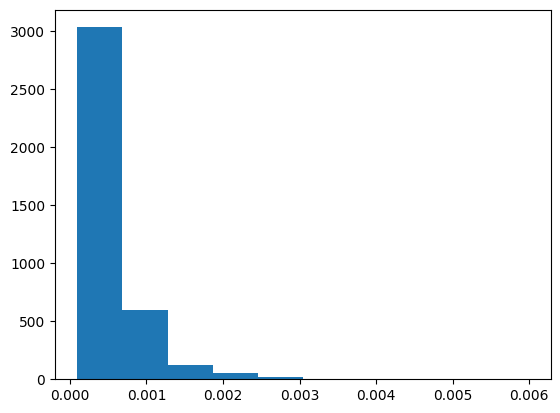

In [6]:
avg_vol_ls = agg_vol(vol)
summary = summary_stats(avg_vol_ls)
print(summary)


plt.hist(avg_vol_ls)
#plt.set_xscale('log')


[9.869844819471185e-05, 0.0004104729372765607, 0.000413255200259961, 0.00041770458436135496, 0.005987980312862796, 0.000544298067307916, 0.0004336730166020211, 0.0004336730166020211]


In [8]:
def all_stocks(stock_ls):
    all_stocks_summary = []

    for filename in stock_ls:
        print(filename)
        stock_df = create_df(filename)

        stock_df = add_wap(stock_df)
        log_returns_ls = calc_log_returns(stock_df)
        # Returns a list of dataframes, each dataframe represents a unique time id. 
        # Each dataframe contains the volatility every 30 seconds. 
        #print(log_returns_ls)
        volatility = calc_volatility(log_returns_ls)
        # 
        agg_ls = agg_vol(volatility)
        summary = summary_stats(agg_ls)
        all_stocks_summary.append(summary)

    df = pd.DataFrame(all_stocks_summary, columns=['minimum', 'q1', 'median', 'q3', 'maximum', 'mean', 'stdev', 'variance'])
    return df



In [17]:
# all_files = all_files[:5]
final_df = all_stocks(all_files)

../individual_book_train/stock_13.csv
../individual_book_train/stock_10.csv
../individual_book_train/stock_38.csv
../individual_book_train/stock_39.csv
../individual_book_train/stock_11.csv
../individual_book_train/stock_29.csv
../individual_book_train/stock_15.csv
../individual_book_train/stock_14.csv
../individual_book_train/stock_28.csv
../individual_book_train/stock_16.csv
../individual_book_train/stock_17.csv
../individual_book_train/stock_124.csv
../individual_book_train/stock_118.csv
../individual_book_train/stock_70.csv
../individual_book_train/stock_8.csv
../individual_book_train/stock_64.csv
../individual_book_train/stock_58.csv
../individual_book_train/stock_59.csv
../individual_book_train/stock_9.csv
../individual_book_train/stock_119.csv
../individual_book_train/stock_125.csv
../individual_book_train/stock_98.csv
../individual_book_train/stock_67.csv
../individual_book_train/stock_73.csv
../individual_book_train/stock_72.csv
../individual_book_train/stock_66.csv
../individ

In [18]:
final_df
final_df.to_csv('summary_stats_optiver.csv')

In [19]:
final_df

,minimum,q1,median,q3,maximum,mean,stdev,variance
0,0.000055,0.000429,0.000425,0.000421,0.010473,0.000572,0.000530,0.000530
1,0.000124,0.000626,0.000621,0.000616,0.007454,0.000812,0.000595,0.000595
2,0.000147,0.000721,0.000730,0.000737,0.010426,0.001001,0.000848,0.000848
3,0.000092,0.000443,0.000436,0.000431,0.008108,0.000616,0.000553,0.000553
4,0.000117,0.000801,0.000793,0.000785,0.013530,0.001039,0.000805,0.000805
...,...,...,...,...,...,...,...,...
107,0.000065,0.000419,0.000418,0.000418,0.007870,0.000561,0.000474,0.000474
108,0.000052,0.001033,0.001045,0.001060,0.011004,0.001358,0.000994,0.000994
109,0.000177,0.000775,0.000778,0.000783,0.007031,0.000988,0.000687,0.000687
110,0.000152,0.000836,0.000845,0.000855,0.007433,0.001064,0.000727,0.000727


{'whiskers': [<matplotlib.lines.Line2D at 0x11d276fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x11d276f70>,
 'boxes': [<matplotlib.lines.Line2D at 0x11d276190>],
 'medians': [<matplotlib.lines.Line2D at 0x11d276f10>],
 'fliers': [],
 'means': []}

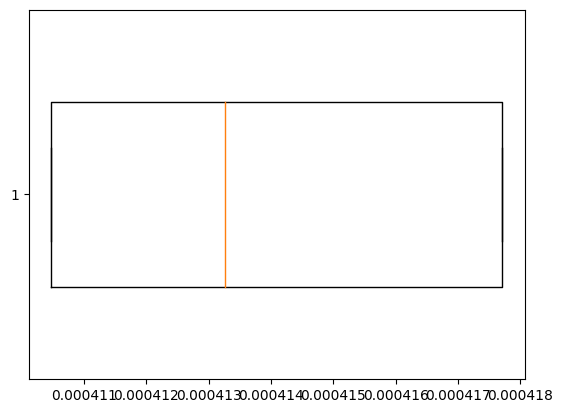

In [61]:
# Visualising boxplot summary:
import matplotlib.pyplot as plt

# fig, ax = plt.subplot()
def my_boxplot(row):
    data = row[0:5]
    fig, ax = plt.subplots()
    g = ax.boxplot([data], widths=0.5, vert=False, sym='o', showfliers=False)
    # ax.set_xscale('log')
    return g

my_boxplot(summary)


In [13]:
final_df = final_df.T
final_df

,0,1,2,3,4
minimum,0.000055,0.000124,0.000147,0.000092,0.000117
q1,0.000429,0.000626,0.000721,0.000443,0.000801
median,0.000425,0.000621,0.000730,0.000436,0.000793
q3,0.000421,0.000616,0.000737,0.000431,0.000785
maximum,0.010473,0.007454,0.010426,0.008108,0.013530
mean,0.000572,0.000812,0.001001,0.000616,0.001039
stdev,0.000530,0.000595,0.000848,0.000553,0.000805
variance,0.000530,0.000595,0.000848,0.000553,0.000805


<AxesSubplot:>

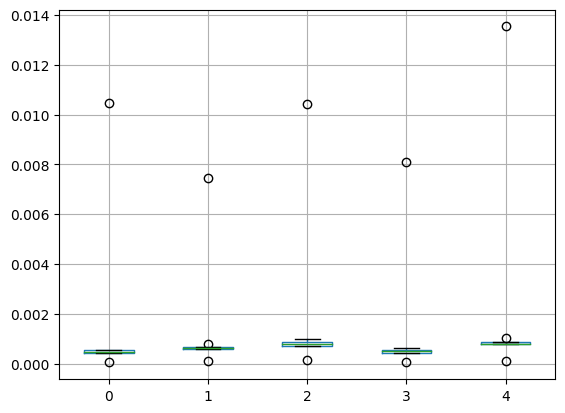

In [14]:
final_df.boxplot()

In [3]:
final_df = pd.read_csv('summary_stats_optiver.csv')

In [55]:
# Entire dataframe
df_ls = np.array_split(final_df, 10)
type(df_ls)

list

In [57]:
df_ls[0]

,minimum,q1,median,q3,maximum,mean,stdev,variance
0,0.000055,0.000429,0.000425,0.000421,0.010473,0.000572,0.000530,0.000530
1,0.000124,0.000626,0.000621,0.000616,0.007454,0.000812,0.000595,0.000595
2,0.000147,0.000721,0.000730,0.000737,0.010426,0.001001,0.000848,0.000848
3,0.000092,0.000443,0.000436,0.000431,0.008108,0.000616,0.000553,0.000553
4,0.000117,0.000801,0.000793,0.000785,0.013530,0.001039,0.000805,0.000805
5,0.000067,0.000341,0.000343,0.000344,0.002797,0.000418,0.000279,0.000279
6,0.000157,0.000650,0.000644,0.000639,0.013859,0.000846,0.000662,0.000662
7,0.000087,0.000487,0.000482,0.000478,0.009251,0.000638,0.000530,0.000530
8,0.000081,0.000503,0.000503,0.000503,0.009904,0.000660,0.000560,0.000560
9,0.000095,0.000667,0.000661,0.000652,0.010742,0.000896,0.000780,0.000780


ValueError: X must have 2 or fewer dimensions

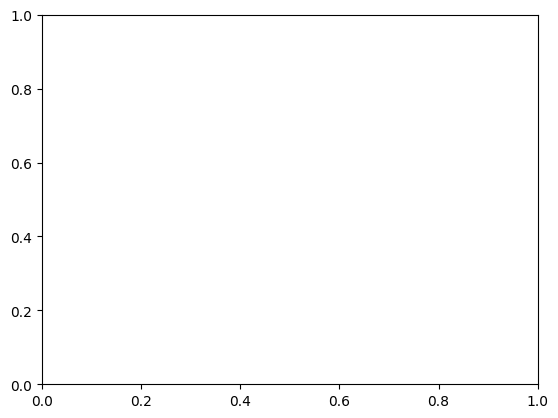

In [62]:
# Visualising boxplot summary:
import matplotlib.pyplot as plt

# fig, ax = plt.subplot()
def my_boxplot(row):
    data = row[0:5]
    fig, ax = plt.subplots()
    g = ax.boxplot([data], widths=0.5, vert=False, sym='o', showfliers=False)
    # ax.set_xscale('log')
    return g

type(df_ls[0])
i = 0

for df in df_ls:
    g = my_boxplot(df)
    name = "plot"+str(i)
    print(df.T.columns)
    fig = g.figure
    fig.savefig(name+".jpg")
    i += 1

AssertionError: 4

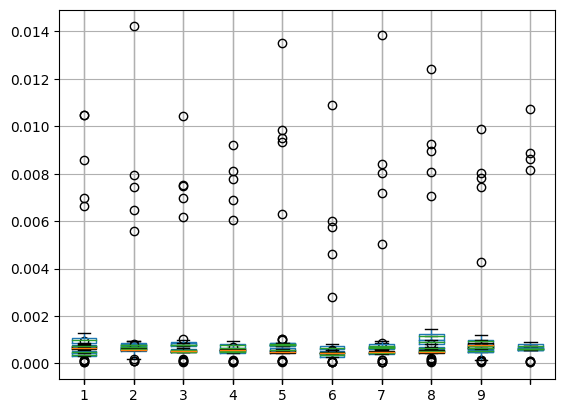

In [45]:
i = 0
for df in df_ls:
    type(df)
    name = "plot"+str(i)
    g = df.T.boxplot()
    fig = g.figure 
    fig.savefig(name+".jpg")
    i += 1

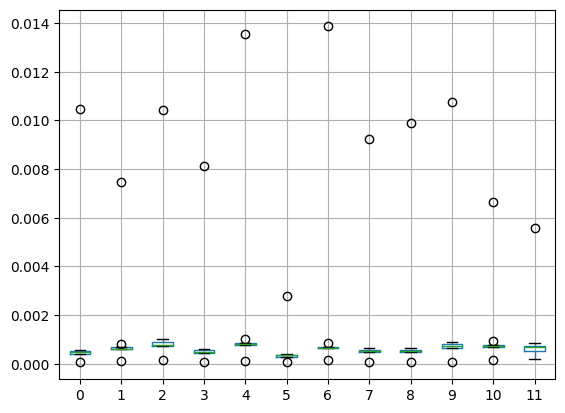

In [56]:
g = df_ls[0].T.boxplot()
fig = g.figure
fig.savefig("plot0.jpg")
# df_ls[1].T.boxplot()
# df_ls[2].T.boxplot()
# df_ls[3].T.boxplot()
# df_ls[4].T.boxplot()
# df_ls[5].T.boxplot()

In [7]:
final_df
from sklearn.cluster import KMeans

kmeans = KMeans(init="random", n_clusters = 3, n_init=10, max_iter=300, random_state=42)
kmeans.fit(final_df)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [8]:
kmeans.inertia_
kmeans.cluster_centers_
kmeans.n_iter_

7

In [13]:
kmeans.labels_[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(final_df)
scaled_df

array([[-1.71665449, -1.31012361, -1.06681008, ..., -1.07479595,
        -0.68461823, -0.68461823],
       [-1.68572378,  0.18549987, -0.18992486, ..., -0.19446504,
        -0.31657378, -0.31657378],
       [-1.65479307,  0.67989228,  0.23049047, ...,  0.49803539,
         1.10585315,  1.10585315],
       ...,
       [ 1.65479307,  1.34647825,  0.47022113, ...,  0.4486133 ,
         0.19733693,  0.19733693],
       [ 1.68572378,  0.79103109,  0.74120354, ...,  0.72733206,
         0.42672379,  0.42672379],
       [ 1.71665449,  0.86994286, -0.19072501, ..., -0.32770317,
        -0.84984501, -0.84984501]])